
# Convolutional Neural Networks for Dog Breed Identification 

---

In this notebook, I provide a fully working code that has already been reviewed by AI and Machine Learning practitioners. You will need to implement additional functionality according your particular application. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions are provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: You can then export the notebook to HTML by using the File menu in Jupyter by navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to code implementation, there are a series of answered questions related to the topic being trained on. 

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

---
### Introduction 

In this notebook, I take a series of steps towards developing an image classification algorithm for dog breed identification that could be incorporated into a mobile or web-based application.  The end goal of the application is to accept any user-supplied image as input.  If a dog is detected in the image, the classifier will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output. 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, we piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  Be aware that there are many points of improvement and to date no AI image classifier is 100% accurate.

### Workflow

The notebook is divided into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

### <font color='blue'>Initialize and configure tensorflow session for GPU deployment. </font> 

I will be running code using tensorflow with GPU support. Below, I configured a tensorflow session manually to allow the tensorflow Keras backend to utilize a single GPU. You can either select to incrementally use or allocate a portion of the available GPU memory to the current session.

In [1]:
#@Juan E. Rolon
#https://github.com/juanerolon/
#Udacity Machine Learning Nanodegree

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()

#Set to True to allow GPU dynamic memory incremental allocation
#Note: memory is not deallocated automatically
if True:
    config.gpu_options.allow_growth = True
    print("GPU memory incrementally allocated for current tensorflow session")

#Set to True if you decide to allocate a specific fraction of the total GPU
#memory to the current tensorflow session
if False:
    mem_frac = 0.3
    config.gpu_options.per_process_gpu_memory_fraction = mem_frac
    print("GPU memory allocated for current tensorflow session = {}".format(mem_frac))
    
set_session(tf.Session(config=config))

#Note: Use the NVIDIA System Management Interface to monitor periodically your gpu compute devices 
#      memory, e.g. $nvdia-smi from bash or using the cell below

!nvidia-smi

Using TensorFlow backend.


GPU memory incrementally allocated for current tensorflow session
Sat Nov  4 11:50:11 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 375.66                 Driver Version: 375.66                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 0000:01:00.0      On |                  N/A |
|  0%   52C    P2    43W / 240W |    241MiB /  8110MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:          

#### <font color='blue'>Generic image loader (used to load my stored validation curves). </font> 

In [112]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline  

def show_image(img_path):
    img = cv2.imread(img_path)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize = (13.0,6.0)) 
    imgplot = plt.imshow(cv_rgb, interpolation='none',aspect='auto')

### <font color='blue'>Import the Dog Dataset</font>

In [2]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [3]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


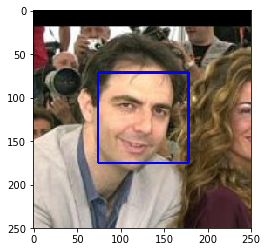

In [4]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [5]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.



**Answer:**

*<br><font color='blue'>What percentage of the first 100 images in `human_files` have a detected human face?</font>*

Percentage of human faces detected in short human_files dataset: 98%

*<br><font color='blue'>What percentage of the first 100 images in `dog_files` have a detected human face?</font>*

Percentage of human faces detected in short dog_files dataset: 11%

In [6]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.


s1, s2 = 0, 0
for human_ipath in human_files_short:
    s1 += face_detector(human_ipath)
for dog_ipath in dog_files_short:
    s2 += face_detector(dog_ipath)

print("Percentage of human faces detected in short human_files dataset: {}".format(s1))
print("Percentage of human faces detected in short dog_files dataset: {}".format(s2))

Percentage of human faces detected in short human_files dataset: 98
Percentage of human faces detected in short dog_files dataset: 11


__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?


#### Answer:
<br>
<font color='green'>In principle we would like to detect faces regardless of their location, orientation, spatial depth or their interlayering with other objects; or even when the image contains defects, or has a low resolution, etc.. As mentioned earlier, face detection with ideal accuracy (99.99%) continues to be challenging. Here are some non-expert opinions:</font>

- <font color='green'> Image pre-processing: apply linear, projective, and non-linear  transformations to standardize images into an optimal format before feeding them into the CNN algorithm. In particular if the original image appears blurry, or distorted in some fashion.</font>

- <font color='green'>Image pre-processing: apply integral transforms such as the discrete Fourier Transform, Wavelet Transform, etc. to aid or speed-up feature extraction within the convolutional layers.</font> 

- <font color='green'>Raw dataset augmentation: augment dataset with raw images containing wide variations of human faces with different locations, orientations, spatial depth and rich context (highly interlayered with other objects).</font>
 

We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on each of the datasets.

In [ ]:
## (Optional) TODO: Report the performance of another  
## face detection algorithm on the LFW dataset
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [7]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

 #### <font color='blue'> After executing the previous cell, tensorflow requests a bit of extra memory ~ 0.3GB. Check the compute process below.</font>

In [8]:
!nvidia-smi

Sat Nov  4 11:55:54 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 375.66                 Driver Version: 375.66                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 0000:01:00.0      On |                  N/A |
|  0%   54C    P8    17W / 240W |    539MiB /  8110MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [9]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [10]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [11]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

**Answer:**

*<br><font color='blue'>What percentage of the first 100 images in `human_files` have a detected dog?</font>*

Percentage of dog faces detected in short human_files dataset: 1%

*<br><font color='blue'>What percentage of the first 100 images in `dog_files` have a detected dog?</font>*

Percentage of dog faces detected in short dog_files dataset: 100%

In [12]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

s1, s2 = 0, 0
for human_ipath in human_files_short:
    s1 += dog_detector(human_ipath)
for dog_ipath in dog_files_short:
    s2 += dog_detector(dog_ipath)

print("Percentage of dog faces detected in short human_files dataset: {}".format(s1))
print("Percentage of dog faces detected in short dog_files dataset: {}".format(s2))

Percentage of dog faces detected in short human_files dataset: 1
Percentage of dog faces detected in short dog_files dataset: 100


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [13]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:06<00:00, 121.38it/s]


 #### <font color='blue'> After executing the previous cell, tensorflow requests about 1.5GB of extra memory. Check the compute process below.</font>

In [14]:
!nvidia-smi

Sat Nov  4 12:04:36 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 375.66                 Driver Version: 375.66                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 0000:01:00.0      On |                  N/A |
|  0%   55C    P8    17W / 240W |   1953MiB /  8110MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

## Answer: 

## <font color='blue'>Basic steps taken to build and implement a CNN architecture:</font> 

**<font color='blue'>Image dataset augmentation.</font>** I augmented both the training and validation datasets by adding random flips and shifts to the original images. This preprocessing benefits the training process and allows the classifier to recognize more variations of the images contained in the validation and testing datasets.<br>
<br>
**<font color='blue'>CNN model architecture.</font>** I increased the depth of the CNN originally proposed above by adding two extra convolutional layers, i.e. one additional layer with 128 filters and another one with 256 filters. This change maintains a reasonable total execution time and yields an increase in testing accuracy.<br> 
<br>
**<font color='blue'>Pre-training analysis.</font>** Before implementing the cnn architecture in the present jupyter notebook I generated a pair of validation curves (*using a separate script*) to determine the number of epochs to train the model; I did this as a primitive step to fine tune the model. These curves are loaded from *png* files generated by matplotlib.<br>
<br>
**<font color='blue'>Expectations.</font>** I don't expect the CNN architecture proposed above to work well. As given, the CNN is not deep enough to discover and distill enough number of features to appropriately characterize and distinguish dog breeds. However, as shown below, a slight increase in depth can increase the model's accuracy up to 40%, which is still not an acceptable performance metric.

### Image augmentation:

In [15]:
#Implements Image Aumentation as done in aind2-cnn jupyter notebook for cifar10
#See https://github.com/udacity/aind2-cnn/blob/master/cifar10-augmentation/

from keras.preprocessing.image import ImageDataGenerator

# create and configure augmented image generator
datagen_train = ImageDataGenerator(
    width_shift_range=0.1,  # randomly shift images horizontally (10% of total width)
    height_shift_range=0.1,  # randomly shift images vertically (10% of total height)
    horizontal_flip=True) # randomly flip images horizontally

# create and configure augmented image generator
datagen_valid = ImageDataGenerator(
    width_shift_range=0.1,  # randomly shift images horizontally (10% of total width)
    height_shift_range=0.1,  # randomly shift images vertically (10% of total height)
    horizontal_flip=True) # randomly flip images horizontally

# fit augmented image generator on data
datagen_train.fit(train_tensors)
datagen_valid.fit(valid_tensors)

### CNN Architecture Model:

In [16]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', 
                        input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=256, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(GlobalAveragePooling2D())
model.add(Dense(133, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 64)        8256      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 128)       32896     
__________

### Compile the Model

In [17]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

### <font color='blue'>Pre-training analysis:</font>

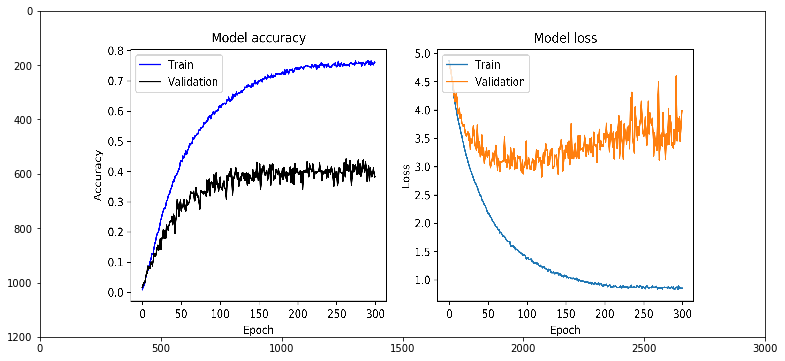

In [113]:
show_image('val_curves/scratch_val_curves.png')

<font color='blue'> The figure above shows plots of the model accuracy and loss function v.s. number epochs for the training and validation sets respectively. The run was implemented in a separate script using a total of 300 epochs and a batch size of 20 samples. The validation loss decays in-between 1 and 100 epochs with significant gains in accuracy. The model shows signs of overfitting when using more than 100 epochs, as the validation loss reverts to an increasing behavior. This suggest using a maximum 100 epochs for model training.</font>

In [ ]:
#@Juan E. Rolon
#I added a couple of modifications to allow for measuring the training time 
#extract the model fitting history from the checkpointer object. We can use the history
#to monitor the accuracy and loss function during the validation process and save the
#performance metrics to a csv file and generate validation curves plots.

import time
from keras.callbacks import ModelCheckpoint

#specify number of epochs and batch_size
epochs = 100
batch_size = 20

#create checkpointer object to store the model weights
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5',
                               verbose=1, save_best_only=True)

init_train_time = time.time()
# Set to True to fit the model to the non-augmented datasets
if False:
    h_scratch = model.fit(train_tensors, train_targets,
              validation_data=(valid_tensors, valid_targets),
              epochs=epochs, batch_size=batch_size, callbacks=[checkpointer], verbose=1)

# Set to True to fit the model to the augmented datasets
if True:
    h_scratch = model.fit_generator(datagen_train.flow(train_tensors, train_targets, batch_size=batch_size),
                        steps_per_epoch=train_tensors.shape[0] // batch_size,
                        epochs=epochs, verbose=1, callbacks=[checkpointer],
                        validation_data=datagen_valid.flow(valid_tensors, valid_targets, batch_size=batch_size),
                        validation_steps=valid_tensors.shape[0] // batch_size)

end_train_time = time.time()
tot_train_time = end_train_time-init_train_time



Epoch 1/100
334/334 [==============================] - 45s - loss: 4.8135 - acc: 0.0163 - val_loss: 4.7578 - val_acc: 0.0244
Epoch 2/100
334/334 [==============================] - 43s - loss: 4.7124 - acc: 0.0246 - val_loss: 4.6854 - val_acc: 0.0329
Epoch 3/100
334/334 [==============================] - 43s - loss: 4.5964 - acc: 0.0370 - val_loss: 4.5312 - val_acc: 0.0390
Epoch 4/100
334/334 [==============================] - 43s - loss: 4.4598 - acc: 0.0404 - val_loss: 4.4047 - val_acc: 0.0512
Epoch 5/100
334/334 [==============================] - 45s - loss: 4.3601 - acc: 0.0519 - val_loss: 4.4034 - val_acc: 0.0683
Epoch 6/100
334/334 [==============================] - 43s - loss: 4.2647 - acc: 0.0585 - val_loss: 4.3213 - val_acc: 0.0573
Epoch 7/100
334/334 [==============================] - 43s - loss: 4.1996 - acc: 0.0659 - val_loss: 4.2906 - val_acc: 0.0561
Epoch 8/100
334/334 [==============================] - 44s - loss: 4.1212 - acc: 0.0775 - val_loss: 4.1668 - val_acc: 0.0646


In [49]:
print("Training time = {0:.3f} minutes ".format(round(tot_train_time/60.0, 3)))

Training time = 73.458 minutes 


### <font color='blue'>Save checkpoints and generate performance metrics plots:</font>

In [35]:
#@Juan E. Rolon
#Added this function to save performance metrics to csv file and generate corresponding
#plots. It receives the checkpointe history object and a desired filename without 
#file extensions. It outputs plots and stores as .csv and .png file respectively.

import pandas as pd

def plotSave_pf_metrics(h, filename): 

    #Save history to CSV file
    history_data = pd.DataFrame(h_scratch.history)
    history_data.to_csv(filename + '.csv')
    
    plt.figure(1, figsize=(10, 4))

    plt.subplot(1,2,1)
    # summarize history for accuracy
    plt.plot(h.history['acc'],color='b')
    plt.plot(h.history['val_acc'],color='k')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')


    plt.subplot(1,2,2)
    # summarize history for loss
    plt.plot(h.history['loss'])
    plt.plot(h.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    #Save and show training and validation performance metrics plots
    plt.savefig(filename + '.png', dpi=300, orientation='landscape')
    plt.show()

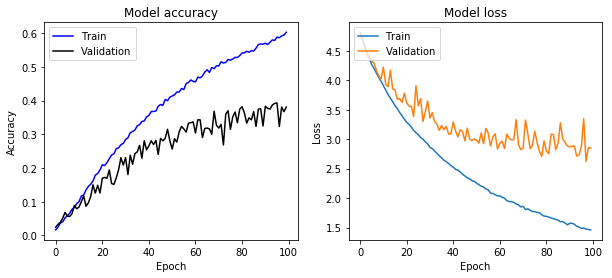

In [39]:
plotSave_pf_metrics(h_scratch, 'scratch_cnn_pf_metrics')

### Load the Model with the Best Validation Loss

In [41]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [42]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 40.0718%


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [44]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [45]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### <font color='blue'>Pre-training analysis:</font>

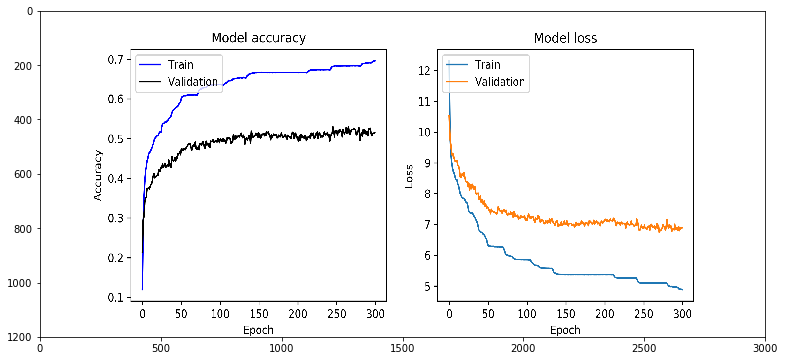

In [114]:
show_image('val_curves/vgg16_val_curves.png')

<font color='blue'> The figure above shows plots of the VGG16 pre-trained model accuracy and loss function v.s. number epochs for the training and validation sets respectively. The run was implemented in a separate script using a total of 300 epochs and a batch size of 20 samples. The validation loss decays in-between 1 and 300 epochs with significant gains in accuracy. Within this range the model does not shows signs of overfitting, as the validation continues to decay with increasing number of epochs. However, it seems tha the validation accuracy saturates and increases at a very low rate. This suggests that we would need a very long run to check whether we can improve accuracy from this point on. Below we train the model for 300 epochs.</font>

### Compile the Model

In [47]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [52]:
#@Juan E. Rolon
#Fit or 'train' model
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5',
                               verbose=1, save_best_only=True)

#specify number of epochs and batch_size
epochs = 300
batch_size = 20

init_train_time_vgg16 = time.time()

# Set to True to fit the model to the non-augmented datasets
if False:
    h_vgg16 = VGG16_model.fit(train_VGG16, train_targets,
                    validation_data=(valid_VGG16, valid_targets),
                    epochs=epochs, batch_size=batch_size, callbacks=[checkpointer], verbose=1)

# Set to True to fit the model to the augmented datasets
if True:
    h_vgg16 = VGG16_model.fit_generator(datagen_train.flow(train_VGG16, train_targets, batch_size=batch_size),
                        steps_per_epoch=train_VGG16.shape[0] // batch_size,
                        epochs=epochs, verbose=1, callbacks=[checkpointer],
                        validation_data=datagen_valid.flow(valid_VGG16, valid_targets, batch_size=batch_size),
                        validation_steps=valid_VGG16.shape[0] // batch_size)

end_train_time_vgg16 = time.time()
tot_train_time_vgg16 = end_train_time_vgg16 - init_train_time_vgg16

/home/rolon/anaconda2/envs/tflow_gpu_opt/lib/python3.5/site-packages/keras/preprocessing/image.py:787: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (6680, 7, 7, 512) (512 channels).
  ' (' + str(self.x.shape[channels_axis]) + ' channels).')
/home/rolon/anaconda2/envs/tflow_gpu_opt/lib/python3.5/site-packages/keras/preprocessing/image.py:787: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (835, 7, 7, 512) (512 channels).
  ' (' + str(self.x.shape[channels_axis]) + ' channels).')


Epoch 1/300
334/334 [==============================] - 77s - loss: 10.1818 - acc: 0.2912 - val_loss: 10.2045 - val_acc: 0.2841
Epoch 2/300
334/334 [==============================] - 75s - loss: 9.8037 - acc: 0.3377 - val_loss: 9.9631 - val_acc: 0.3122
Epoch 3/300
334/334 [==============================] - 75s - loss: 9.4692 - acc: 0.3675 - val_loss: 9.7202 - val_acc: 0.3378
Epoch 4/300
334/334 [==============================] - 75s - loss: 9.2998 - acc: 0.3925 - val_loss: 9.8034 - val_acc: 0.3329
Epoch 5/300
334/334 [==============================] - 75s - loss: 9.2370 - acc: 0.4076 - val_loss: 9.6702 - val_acc: 0.3500
Epoch 6/300
334/334 [==============================] - 75s - loss: 9.2190 - acc: 0.4099 - val_loss: 9.5684 - val_acc: 0.3671
Epoch 7/300
334/334 [==============================] - 75s - loss: 9.1851 - acc: 0.4178 - val_loss: 9.5651 - val_acc: 0.3695
Epoch 8/300
334/334 [==============================] - 75s - loss: 9.1383 - acc: 0.4199 - val_loss: 9.4444 - val_acc: 0.363

In [53]:
print("Training time = {0:.3f} minutes ".format(round(tot_train_time_vgg16/60.0, 3)))

Training time = 378.446 minutes 


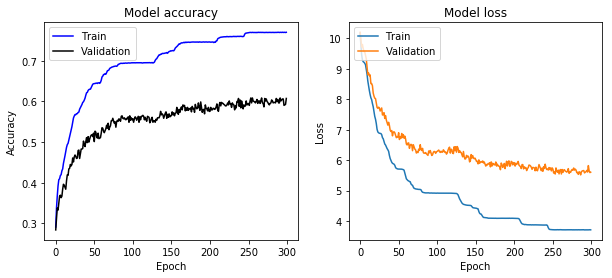

In [54]:
plotSave_pf_metrics(h_vgg16, 'vgg16_cnn_pf_metrics')

### Load the Model with the Best Validation Loss

In [55]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [56]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 60.8852%


### Predict Dog Breed with the Model

In [59]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

## <font color='blue'>Image classifier:</font>

In [60]:
#@Juan E. Rolon
#Added this function to save performance metrics to csv file and generate corresponding
#plots. It receives the checkpointe history object and a desired filename without 
#file extensions. It outputs plots and stores as .csv and .png file respectively.
# determines and returns whether the image contains a human, dog, or neither

def classify_image(predictor, img_path):
    img = cv2.imread(img_path)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    imgplot = plt.imshow(cv_rgb)

    if face_detector(img_path):
        pred = predictor(img_path)
        breed = pred.rpartition('/')[-1].rpartition('.')[-1].replace('_', ' ')
        print("Human face detected in image")
        print("This human looks like a {}".format(breed))
        return
    elif dog_detector(img_path):
        pred = predictor(img_path)
        breed = pred.rpartition('/')[-1].rpartition('.')[-1].replace('_', ' ')
        print("Dog face detected in image")
        print("This dog looks like a {}".format(breed))
    else:
        print("Non identifiable dog nor human faces detected")

58761216/58889256 [============================>.] - ETA: 0sDog face detected in image
This dog looks like a Belgian malinois


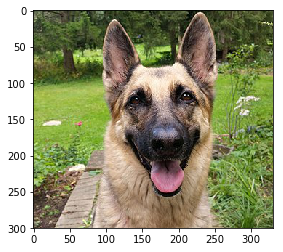

In [61]:
classify_image(VGG16_predict_breed, 'my_test_images/German_Shepherd.jpg')

Dog face detected in image
This dog looks like a Chihuahua


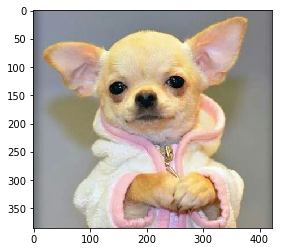

In [62]:
classify_image(VGG16_predict_breed, 'my_test_images/Chihuahua.jpg')

Dog face detected in image
This dog looks like a Poodle


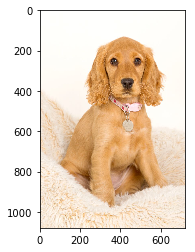

In [64]:
classify_image(VGG16_predict_breed,'my_test_images/Cocker_spaniel.jpg')

Dog face detected in image
This dog looks like a Greyhound


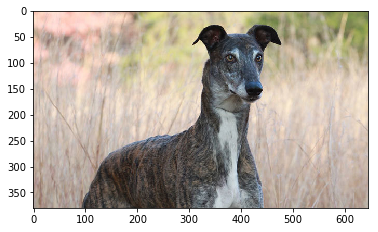

In [69]:
classify_image(VGG16_predict_breed,'my_test_images/Greyhound.jpg')

### <font color='blue'>Description of the VGG16 classification results:</font>

<font color='green'>As shown abve, the VGG16 image classifier was able to detect correctly two dog breeds out of 4 given images. The result is consistent with the computed accuracy of ~60%. It will be possible to attain higher accuracy by further fine-training the model and by letting it run by a larger number of epochs (>300 epochs) before reaching the overfitting regime.</font>

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [65]:
bottleneck_features = np.load('bottleneck_features/DogResnet50Data.npz')
train_ResNet50 = bottleneck_features['train']
valid_ResNet50 = bottleneck_features['valid']
test_ResNet50 = bottleneck_features['test']

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

### Answer: 



## <font color='blue'>Steps taken to build and implement the CNN architecture:</font><br> 
**<font color='blue'>Image dataset augmentation.</font>** As done before, I augmented the input datasets to help improving the algorithm's performance metrics.<br>
<br>
**<font color='blue'>Bottleneck features.</font>** Since we are implementing transfer learning from a ResNet50 CNN that was extensively trained for visual recognition in a different dataset, we need to extract only the corresponding bottleneck features from it. This original network can't be used directly to classify dog breeds in our problem as it was not trained using our datasets.

However, we can imagine that the previous ResNet50 CNN is composed of two parts:  
<br>
1. a subnetwork made up of several layers, starting from the input layer up to some intermediate layer $k$. This subnetwork implements a mapping from the input manifold to a lower $n_k$-dimensional vector space. Therefore, due to its reduced dimensionality the $k-th$ layer is a *bottleneck layer*. Usually, it is expected that the vector of activations nodes in this layer would provide the features (*bottleneck features*) necessary to represent dog faces in a generic manner in our problem. Finally, we may opt to keep only the bottleneck layer and feed it as input to the model of our choice.<br>
<br>

2. the second part (or subnetwork) of the previous ResNet50, starting at the $k+1$ layer up to the output layer is discarded and replaced by the layers of our choice tailored specifically to the needs of our problem.<br>
<br>

**<font color='blue'>Additional new layers.</font>** As we assume that the bottleneck features were carefully extracted from a related visual recognition problem, we would only add two layer to our new model: 

1. Global average pooling.- would reduce each of the feature maps in the bottleneck layer to single values, effectively performing a flattening operation. 

2. Dense linear output layer.- the output of the average pooling is fed into a dense layer whose linear dimension agrees with the number of categories or classes in our problem. We use a typical softmax activation for the nodes in this layer.
<br>

**<font color='blue'>Performance expectations.</font>** The transfer learning model should work much better. As shown below it achieves a 83.13% accuracy. This is the probable result of using the knowledge (bottleneck features) gathered by the previous ResNet50 CNN trained extensively in a similar pattern recognition problem.

In [66]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense, Activation
from keras.models import Sequential

ResNet_model = Sequential()
ResNet_model.add(GlobalAveragePooling2D(input_shape=train_ResNet50.shape[1:]))
ResNet_model.add(Dense(133, activation='softmax'))

ResNet_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


### <font color='blue'>Pre-training analysis:</font>

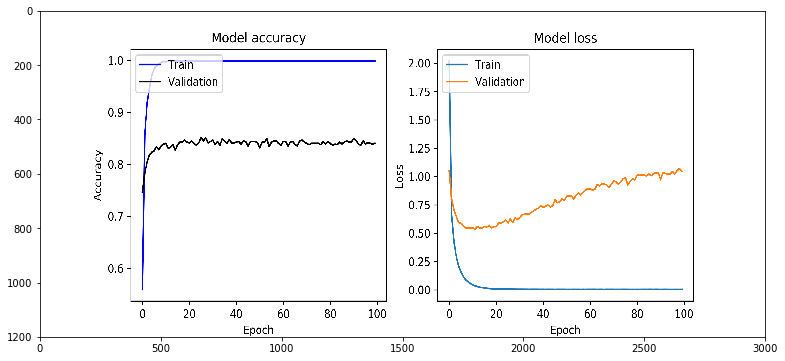

In [115]:
show_image('val_curves/resnet50_val_curves.png')

<font color='blue'> The figure above shows plots of the ResNet50 pre-trained model accuracy and loss function v.s. number epochs for the training and validation sets respectively. The run was implemented in a separate script using a total of 100 epochs and a batch size of 20 samples. The validation loss decays in-between 1 and 20 epochs with significant gains in accuracy. Beyond this range the model shows signs of overfitting, as the validation reverts to an increasing behavior as we add more epochs. The validation accuracy saturates very quickly around 20 epochs. This suggests that we need about 20 epochs to attain good accuracy and avoid overfitting.</font>

### (IMPLEMENTATION) Compile the Model

In [68]:
from keras.optimizers import Adamax

ResNet_model.compile(loss='categorical_crossentropy', optimizer=Adamax(lr=0.002), metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [73]:
#Fit or 'train' model
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.ResNet50.hdf5',
                               verbose=1, save_best_only=True)

#Specify number of epochs and batch_size
epochs = 20
batch_size = 20


init_train_time_rsnt50 = time.time()

# Set to True to fit the model to the non-augmented datasets
if False:
    h_rsnt50 = ResNet_model.fit(train_ResNet50, train_targets,
          validation_data=(valid_ResNet50, valid_targets),
          epochs=epochs, batch_size=batch_size, callbacks=[checkpointer], verbose=1)

# Set to True to fit the model to the augmented datasets
if True:
    h_rsnt50 = ResNet_model.fit_generator(datagen_train.flow(train_ResNet50, train_targets, batch_size=batch_size),
                        steps_per_epoch=train_ResNet50.shape[0] // batch_size,
                        epochs=epochs, verbose=1, callbacks=[checkpointer],
                        validation_data=datagen_valid.flow(valid_ResNet50, valid_targets, batch_size=batch_size),
                        validation_steps=valid_ResNet50.shape[0] // batch_size)

end_train_time_rsnt50 = time.time()
tot_train_time_rsnt50 = end_train_time_rsnt50 - init_train_time_rsnt50

/home/rolon/anaconda2/envs/tflow_gpu_opt/lib/python3.5/site-packages/keras/preprocessing/image.py:787: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (6680, 1, 1, 2048) (2048 channels).
  ' (' + str(self.x.shape[channels_axis]) + ' channels).')
/home/rolon/anaconda2/envs/tflow_gpu_opt/lib/python3.5/site-packages/keras/preprocessing/image.py:787: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (835, 1, 1, 2048) (2048 channels).
  ' (' + str(self.x.shape[channels_axis]) + ' channels).')


Epoch 1/20
334/334 [==============================] - 291s - loss: 0.6712 - acc: 0.8476 - val_loss: 0.8163 - val_acc: 0.7744
Epoch 2/20
334/334 [==============================] - 284s - loss: 0.4247 - acc: 0.9111 - val_loss: 0.6837 - val_acc: 0.8037
Epoch 3/20
334/334 [==============================] - 286s - loss: 0.2964 - acc: 0.9463 - val_loss: 0.6232 - val_acc: 0.8122
Epoch 4/20
334/334 [==============================] - 283s - loss: 0.2147 - acc: 0.9692 - val_loss: 0.5948 - val_acc: 0.8280
Epoch 5/20
334/334 [==============================] - 285s - loss: 0.1565 - acc: 0.9810 - val_loss: 0.5830 - val_acc: 0.8220
Epoch 6/20
334/334 [==============================] - 286s - loss: 0.1184 - acc: 0.9891 - val_loss: 0.5599 - val_acc: 0.8317
Epoch 7/20
334/334 [==============================] - 287s - loss: 0.0899 - acc: 0.9943 - val_loss: 0.5524 - val_acc: 0.8268
Epoch 8/20
334/334 [==============================] - 285s - loss: 0.0706 - acc: 0.9960 - val_loss: 0.5264 - val_acc: 0.8415


In [74]:
print("Training time = {0:.3f} minutes ".format(round(tot_train_time_rsnt50/60.0, 3)))

Training time = 95.461 minutes 


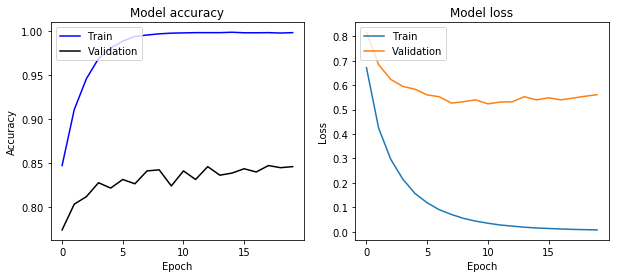

In [75]:
plotSave_pf_metrics(h_rsnt50, 'rsnt50_cnn_pf_metrics')

### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [76]:
ResNet_model.load_weights('saved_models/weights.best.ResNet50.hdf5')

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [77]:
ResNet50_predictions = [np.argmax(ResNet_model.predict(np.expand_dims(feature, axis=0))) for feature in test_ResNet50]
test_accuracy = 100*np.sum(np.array(ResNet50_predictions)==np.argmax(test_targets, axis=1))/len(ResNet50_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 83.1340%


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [78]:
from extract_bottleneck_features import *

def Resnet50_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = ResNet_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

## <font color='blue'>Image classifier:</font>

In [81]:
#@Juan E. Rolon
#Added this function to save performance metrics to csv file and generate corresponding
#plots. It receives the checkpointe history object and a desired filename without 
#file extensions. It outputs plots and stores as .csv and .png file respectively.
# determines and returns whether the image contains a human, dog, or neither

def classify_image(predictor, img_path):
    img = cv2.imread(img_path)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    imgplot = plt.imshow(cv_rgb)

    if face_detector(img_path):
        pred = predictor(img_path)
        breed = pred.rpartition('/')[-1].rpartition('.')[-1].replace('_', ' ')
        print("Human face detected in image")
        print("This human looks like a {}".format(breed))
        return
    elif dog_detector(img_path):
        pred = predictor(img_path)
        breed = pred.rpartition('/')[-1].rpartition('.')[-1].replace('_', ' ')
        print("Dog face detected in image")
        print("This dog looks like a {}".format(breed))
    else:
        print("Non identifiable dog nor human faces detected")

---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.


### Answer: 
<br>
<font color='green'> I tested the algorithm on several images not contained in the original datasets. The output was much better when compared to the previous implementations.</font>

- <font color='green'> For images containing dogs, the algorithm correctly identified the corresponding dog breed on each image in agreement with the reported accuracy of 83%.</font>

- <font color='green'> I also fed the images of a Cat and a Wolf and in both cases the algorithm did not detect a dog nor a human face.</font>

- <font color='green'> I fed the images of 3 human faces, including the snapshot of an anime movie. In all cases the algorithm detected a human face.</font>

#### <font color='green'> Points of improvement:</font>

**<font color='green'>Segment images to allow the image detector and/or classifier scan more than one face.</font>** As is, the algorithm cannot identify more than one breed in an image containing several dogs of different breeds. Below, I fed an image containing 3 dogs and the algorithm classified  (correctly) one dog while ignoring the others. My intuition is that it picked the one with the highest probability.

**<font color='green'>Allow or augment datasets for wider color variations and interlayering with similar objects.</font>** It seems that color variations due to interlayering with nearby similar objects obfuscates the algorithm. I fed the algorithm an image of a *Labrador Retriever* seated together with cat with similar hair color and higher orange tonality. I also fed an image of a single Labrador with higher orange tonality. In both cases, the algorithm classified the image incorrectly as being a *Golden Retriever* 

**<font color='green'>Fine-tune the algorithm to better classify images of animals closely resembling a dog.</font>** I fed the algorithm with an image of a Dingo (a feral wild dog) which the algorithm classified incorrectly as a Collie. A possible solution is to write separate face detectors for closely resembling species. 

### <font color='blue'> Succesful cases:</font>

Dog face detected in image
This dog looks like a German shepherd dog


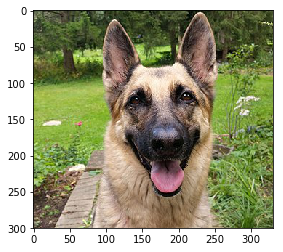

In [82]:
classify_image(Resnet50_predict_breed, 'my_test_images/German_Shepherd.jpg')

Dog face detected in image
This dog looks like a Chihuahua


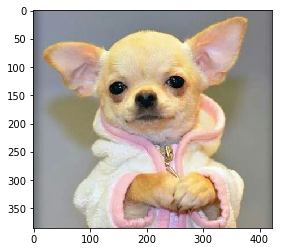

In [83]:
classify_image(Resnet50_predict_breed, 'my_test_images/Chihuahua.jpg')

Dog face detected in image
This dog looks like a English cocker spaniel


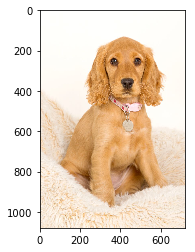

In [84]:
classify_image(Resnet50_predict_breed,'my_test_images/Cocker_spaniel.jpg')

Dog face detected in image
This dog looks like a Italian greyhound


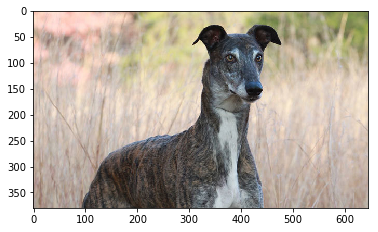

In [85]:
classify_image(Resnet50_predict_breed,'my_test_images/Greyhound.jpg')

Human face detected in image
This human looks like a Alaskan malamute


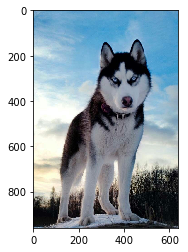

In [96]:
classify_image(Resnet50_predict_breed,'my_test_images/Husky.jpg')

Dog face detected in image
This dog looks like a Labrador retriever


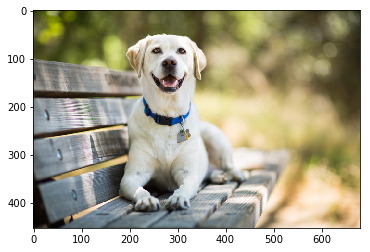

In [97]:
classify_image(Resnet50_predict_breed,'my_test_images/Labrador.jpg')

Dog face detected in image
This dog looks like a Labrador retriever


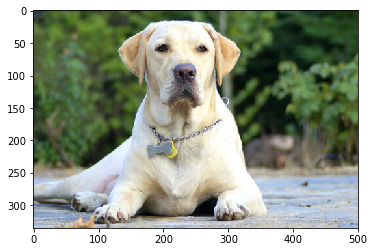

In [98]:
classify_image(Resnet50_predict_breed,'my_test_images/Labrador2.jpg')

Non identifiable dog nor human faces detected


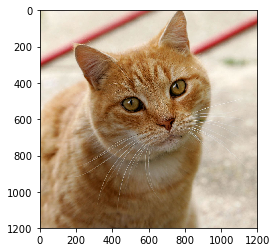

In [86]:
classify_image(Resnet50_predict_breed,'my_test_images/Cat.jpg')

Non identifiable dog nor human faces detected


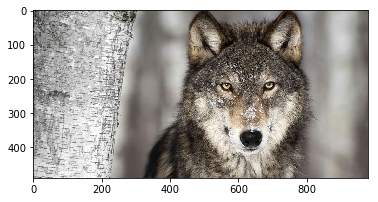

In [111]:
classify_image(Resnet50_predict_breed,'my_test_images/Wolf.jpg')

Human face detected in image
This human looks like a Silky terrier


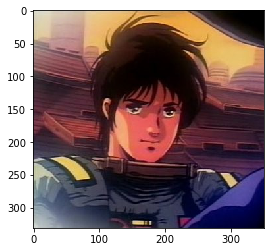

In [92]:
classify_image(Resnet50_predict_breed,'my_test_images/Hikaru.jpg')

Human face detected in image
This human looks like a Manchester terrier


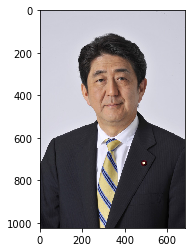

In [93]:
classify_image(Resnet50_predict_breed,'my_test_images/Shinzo-Abe.jpeg')

Human face detected in image
This human looks like a Papillon


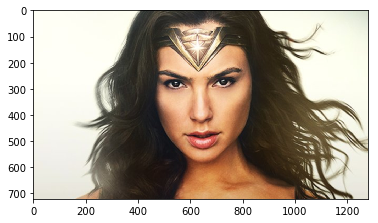

In [94]:
classify_image(Resnet50_predict_breed,'my_test_images/WW.jpeg')

### <font color='blue'> Non-standard cases suggesting need for improvement:</font>

Dog face detected in image
This dog looks like a Doberman pinscher


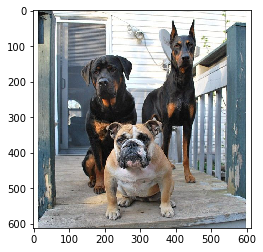

In [105]:
classify_image(Resnet50_predict_breed,'my_test_images/3dogs.jpg')

Dog face detected in image
This dog looks like a Golden retriever


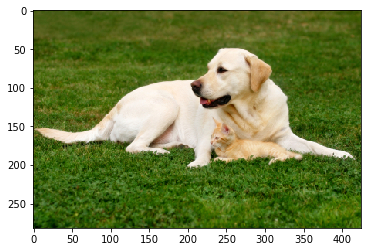

In [99]:
classify_image(Resnet50_predict_breed,'my_test_images/Labrador3.jpg')

Dog face detected in image
This dog looks like a Golden retriever


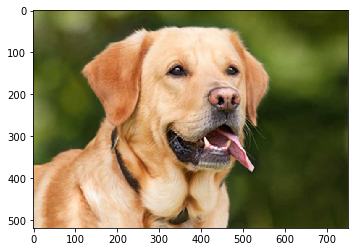

In [103]:
classify_image(Resnet50_predict_breed,'my_test_images/Labrador4.jpg')

Dog face detected in image
This dog looks like a Collie


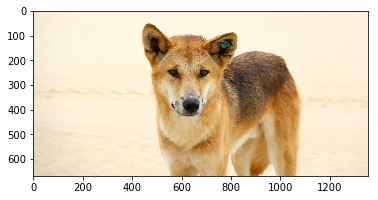

In [109]:
classify_image(Resnet50_predict_breed,'my_test_images/Dingo.jpg')